In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
from PIL import Image


path = "ROIs1158_spring/s2_24/ROIs1158_spring_s2_24_p30.tif"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


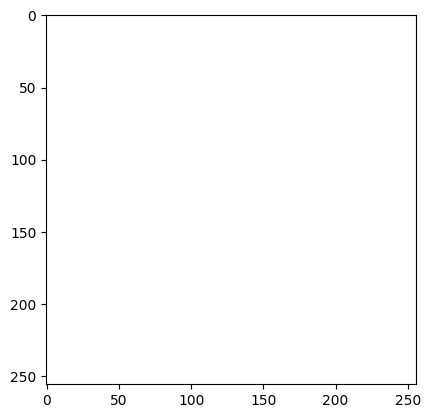

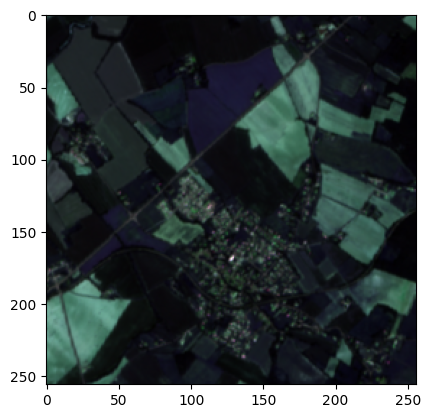

In [1]:
from torchvision.transforms import ToTensor
import rasterio
from rasterio.plot import show
import numpy as np
import torch
import matplotlib.pyplot as plt

from osgeo import gdal as GD

# bands 1, 2, 3 = R G B
path = "Input/SEN12MS_test/s_2/ROIs1158_spring_s2_2_p30.tif"
path = "C:/Users/Paddy/CRT/Github/input/ROIs1158_spring/train/s2_148/ROIs1158_spring_s2_148_p30.tif"
path1 = "10078.tiff"
with rasterio.open(path) as image:
    image_array = image.read([2,3,4])


#norm_array = image_array * (255.0/image_array.max())
norm_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())

show(image_array)

src = rasterio.open(path)

# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Convert to numpy arrays
blue = src.read(4).astype(np.int32)
green = src.read(3).astype(np.int32)
red = src.read(2).astype(np.int32)

# Normalize band DN
nir_norm = normalize(blue)
red_norm = normalize(red)
green_norm = normalize(green)

# Stack bands
nrg = np.dstack((red_norm, nir_norm, green_norm))

# View the color composite
plt.imshow(nrg)

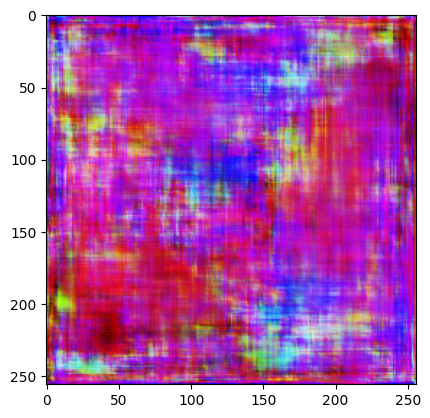

<Axes: >

In [3]:
from torchvision.transforms import ToTensor
import rasterio
from rasterio.plot import show
import numpy as np
import torch
img = torch.load("generated_images/step6_epoch24_2.pt").detach().cpu().numpy()

R = img[0][1]
G = img[0][2]
B = img[0][3]

img_1 = np.dstack((R,G,B))
show(np.transpose(img_1, (2,1,0)))

In [13]:
import os

import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log2

import random
import torchvision
from torchvision.utils import save_image
from torch.utils.data import Dataset
from osgeo import gdal as GD

from typing import Tuple, Dict, List
import pathlib

import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

START_TRAIN_IMG_SIZE = 16
DATASET = r"C:/Users/Paddy/CRT/Github/input/ROIs1158_spring/train"
print(os.path.dirname(os.getcwd()))
#DATASET = "Input/SEN12MS_sample"

CHECKPOINT_GEN = "Generator_Attempt.pt"
CHECKPOINT_CRITIC = "Critic_Attempt.pt"
SAVE_MODEL = True
LOAD_MODEL = False

LR = 1e-3
BATCH_SIZES = [256,256,128,64,32,16,8] ## modifiable/ Batch_sizes for each step
IMAGE_SIZE = 256 ## 1024 for paper
IMG_CHANNELS = 3
Z_DIM = 256 ## 512 for paper
IN_CHANNELS = 256 ## 512 for paper
LAMBDA_GP = 10
NUM_STEPS = int(log2(IMAGE_SIZE/4)) + 1

PROGRESSIVE_EPOCHS = [5] * len(BATCH_SIZES)
FIXED_NOISE = torch.randn(8,Z_DIM,1,1).to(DEVICE)
# NUM_WORKERS = 4
NUM_WORKERS = 0 # have to set to zero otherwise get an error
torch.backends.cudnn.benchmarks = True


print(DEVICE)
print(DATASET)

# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

class SEN12MS(Dataset):
    """Custom dataset for SEN12MS data"""

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.tif")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        image = rasterio.open(str(image_path)).read([2,3,4])
        image_norm = cv2.normalize(image.astype(np.float32), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        #norm_image = (image - image.min()) / (image.max() - image.min())
        return np.transpose(image_norm,(1,2,0))
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

c:\Users\Paddy\CRT\Github
cuda
C:/Users/Paddy/CRT/Github/input/ROIs1158_spring/train


In [15]:
from torch.nn.functional import normalize
import matplotlib.pyplot as plt
transform_sen = transforms.Compose(
    [
        transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize([0.5 for _ in range(IMG_CHANNELS)],[0.5 for _ in range(IMG_CHANNELS)])
    ])
dataset = SEN12MS(targ_dir=DATASET, transform=transform_sen)

img_test = dataset[1][0].numpy()
test_norm = cv2.normalize(img_test.astype(np.float32), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
print(test_norm.shape)

cv2.imshow('sen12ms_dataloader', np.transpose(test_norm, (1, 2, 0)))
cv2.waitKey(0)
cv2.destroyAllWindows()

(3, 256, 256)


In [1]:
import cv2
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np

path = "ROIs1158_spring_s2_1_p30.tif"
with rasterio.open(path) as image:
    image_array_full = image.read()

print(image_array_full.shape)
img_scaled_full = cv2.normalize(image_array_full.astype(np.float64), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

print(img_scaled_full[0, :, :])

with rasterio.open(path) as image:
    image_array_rgb = image.read([2,3,4])

print(image_array_rgb.shape)
img_scaled_rgb = cv2.normalize(image_array_rgb.astype(np.float64), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

print(img_scaled_rgb[0, :, :])

cv2.imshow('sen12ms', np.transpose(img_scaled_full[1:4, :, :], (1, 2, 0)))
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow('sen12ms', np.transpose(img_scaled_rgb, (1, 2, 0)))
cv2.waitKey(0)
cv2.destroyAllWindows()

RasterioIOError: ROIs1158_spring_s2_1_p30.tif: No such file or directory

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log2
from rasterio.plot import show
import numpy as np

import random
import torchvision

import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from typing import Tuple, Dict, List
from torch.utils.data import Dataset
import pathlib
import rasterio
import cv2

from wopt.ml import transforms as tf

IMG_CHANNELS = 3
BATCH_SIZES = [32,32,32,32,16,16,16,4,4,4]
DATASET = os.path.join(os.path.dirname(os.getcwd()), "input/ROIs1158_spring/test/") #"input/Faces") 
NUM_WORKERS = 2

# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


class SEN12MS(Dataset):
    """Custom dataset for SEN12MS data"""

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.tif")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int):# -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        image = rasterio.open(str(image_path)).read([2,3,4])
        image_norm = cv2.normalize(image.astype(np.float32), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        #norm_image = (image - image.min()) / (image.max() - image.min())
        return np.transpose(image_norm,(1,2,0))
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

def get_loader(img_size):
    transform = transforms.Compose(
    [
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5)#,
        #transforms.Normalize([0.5 for _ in range(IMG_CHANNELS)],[0.5 for _ in range(IMG_CHANNELS)])
    ])
    transform_sen = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((img_size,img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize([0.5 for _ in range(IMG_CHANNELS)],[0.5 for _ in range(IMG_CHANNELS)])
    ])
    
    dataset = SEN12MS(targ_dir=DATASET, transform=transform_sen)

    batch_size = BATCH_SIZES[int(log2(img_size/4))]
    #dataset = datasets.ImageFolder(root=DATASET,transform=transform)

    loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=NUM_WORKERS,pin_memory=True)
    
    return loader,dataset

def plot_cv(img):
    cv2.imshow('image_plot', np.transpose(img, (1,2,0)))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

loader, data = get_loader(0)
img = data[0][0].numpy()



#plot_cv(img)


ValueError: math domain error